# 雲天による遮光率のモデリング
- 雲は日光を遮る．衛星画像によって遮光率の値が分かっていると仮定しこれを統計モデルによって再現する．
    - 遮光率１：完全に雲
    - 遮光率０：晴天
- 1次元の疑似データを生成する
    - 混合数 3
    - ガウス分布の平均・分散パラメータ $\mu = \{2, 5, 8\} , \sigma^{2} = \{1, 1, 1\}$
    - 混合比 $\pi = \{0.3, 0.5, 0.2\}$
    - シグモイド係数　$a, b$ 
        - $\mathrm{sigmoid}(z) = \frac{1}{1+\exp{(-z)}}, z=ax +b$
    - 疑似データ $f(x) = u\left( \sum_{i} \pi_{i}\mathcal{N}(x ; \mu_{i}, \sigma_{i}^{2}) \right), u(x) = \mathrm{sigmoid(x)}$
- ガウス混合分布に対してシグモイド関数による変換を施すことで値を[0, 1]に収める
- 推定の設定
    - ガウス分布の混合数は既知とする
- 推定パラメータ
    - ガウス分布の平均・分散パラメータ　$ \mu, \sigma$
    - 混合比の重み $\pi$
- シグモイドの係数 $a, b$は別の方法で推定した方が良い？

In [9]:
%load_ext autoreload
%autoreload 2
%matplotlib inline 

import sys, os
sys.path.append(os.pardir)
import numpy as np
import matplotlib.pyplot as plt
import itertools
from common.gradient import numerical_gradient
from common.optimizer import SGD, AdaGrad, Adam
from PIL import Image
from scipy.stats import multivariate_normal
from mpl_toolkits.mplot3d.axes3d import Axes3D
import pdb
import time
from tqdm import tqdm
from Slackutil.SendMessage import SendMessage

from MakeData import EpnTrue
from uEpanechnikovMMNet import uEpaMMNet
from misc import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
TrueModel = EpnTrue(mixture_size=20)
Data = TrueModel.Generate()
Data = Data.T.reshape(Data.shape[0]*Data.shape[1])
Model = uEpaMMNet(mixture_size=20)
# Model.params

 98%|█████████▊| 49/50 [09:19<00:11, 11.29s/it]

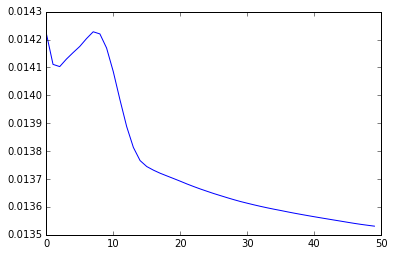

100%|██████████| 50/50 [09:31<00:00, 11.46s/it]


In [63]:
losslist = []
gradslist = []

iterate = 50

LearningRate = 50
epsilon = 0.001

epoch = iterate

optimizer = Adam()

for i in tqdm(range(iterate)):
    
    Model.LayerBuild()
    
    Gr = []
    loss = []
    for xyt, d in zip(Model.xyt, Data):
        Gr.append(Model.Gradient(x = xyt, f = d))
        loss.append(Model.lastLayer.loss) 
    
    # pdb.set_trace()
    grads = {}
    for key in Model.params.keys():
        grads[key] = np.mean(np.array([G[key] \
                                       for G in Gr]),
                             axis = 0)
        Model.params[key] -= LearningRate * grads[key]
        
    gradslist.append(grads)
    
    # optimizer.update(params = Model.params, grads = grads)
        
    Model.params['pi'][Model.params['pi'] < epsilon] = epsilon
    Model.params['pi'] = Model.params['pi']/np.sum(Model.params['pi'])
    
    losslist.append(np.mean(loss))
     
    # pdb.set_trace()
        
    # print(str(i))
    if((i+1)%epoch == 0):
        plt.plot(range(i+1), losslist)
        plt.show()
        

Mess = SendMessage(message = 'code finished!')
Mess.send()

In [14]:
print('0', gradslist[0]['covs'])
print('1', gradslist[1]['covs'])

0 [[[  1.69140094e-05   5.53267118e-07]
  [  5.53267118e-07   1.38868785e-05]]

 [[  2.37598062e-05   1.38347833e-07]
  [  1.38347833e-07   2.70183625e-05]]

 [[  6.16445852e-05  -1.04005099e-06]
  [ -1.04005099e-06   6.37880717e-05]]

 [[  2.02913596e-05   4.67326699e-07]
  [  4.67326699e-07   1.28641779e-05]]

 [[  9.03666986e-05   1.13363118e-06]
  [  1.13363118e-06   7.50223509e-05]]

 [[  5.84651189e-06  -3.46430278e-06]
  [ -3.46430278e-06   1.25324481e-05]]

 [[  2.64634627e-06  -3.93637206e-06]
  [ -3.93637206e-06   2.08449100e-05]]

 [[ -4.32113380e-05  -7.65066197e-06]
  [ -7.65066197e-06   1.04660143e-06]]

 [[  8.64989674e-05   1.66536967e-06]
  [  1.66536967e-06   8.42419884e-05]]

 [[  1.08324064e-04   1.05148723e-05]
  [  1.05148723e-05   7.03812135e-05]]

 [[  1.09814172e-04   1.03972657e-05]
  [  1.03972657e-05   1.37325978e-04]]

 [[  4.23261106e-06   1.11565224e-05]
  [  1.11565224e-05   1.71991567e-05]]

 [[  1.96302989e-05   1.57461111e-06]
  [  1.57461111e-06   1.

In [40]:
for i in range(12500):
    print(Gr[i]['mus']) 

[[-0. -0.]
 [-0. -0.]
 [-0. -0.]
 [-0.  0.]
 [-0. -0.]
 [-0. -0.]
 [-0. -0.]
 [-0. -0.]
 [-0. -0.]
 [-0. -0.]
 [-0. -0.]
 [-0. -0.]
 [-0. -0.]
 [-0. -0.]
 [-0. -0.]
 [-0. -0.]
 [-0. -0.]
 [-0. -0.]
 [-0. -0.]
 [-0. -0.]]
[[-0. -0.]
 [-0. -0.]
 [-0. -0.]
 [-0.  0.]
 [-0. -0.]
 [-0. -0.]
 [-0. -0.]
 [-0. -0.]
 [-0. -0.]
 [-0. -0.]
 [-0. -0.]
 [-0. -0.]
 [-0. -0.]
 [-0. -0.]
 [-0. -0.]
 [-0. -0.]
 [-0. -0.]
 [-0. -0.]
 [-0. -0.]
 [-0. -0.]]
[[-0. -0.]
 [-0. -0.]
 [-0. -0.]
 [-0.  0.]
 [-0. -0.]
 [-0. -0.]
 [-0. -0.]
 [-0.  0.]
 [-0. -0.]
 [-0. -0.]
 [-0. -0.]
 [-0. -0.]
 [-0. -0.]
 [-0. -0.]
 [-0. -0.]
 [-0. -0.]
 [-0. -0.]
 [-0. -0.]
 [-0. -0.]
 [-0. -0.]]
[[-0. -0.]
 [-0. -0.]
 [-0. -0.]
 [-0.  0.]
 [-0. -0.]
 [-0. -0.]
 [-0. -0.]
 [-0.  0.]
 [-0. -0.]
 [-0. -0.]
 [-0. -0.]
 [-0. -0.]
 [-0. -0.]
 [-0. -0.]
 [-0. -0.]
 [-0. -0.]
 [-0. -0.]
 [-0. -0.]
 [-0. -0.]
 [-0. -0.]]
[[-0. -0.]
 [-0. -0.]
 [-0. -0.]
 [-0.  0.]
 [-0. -0.]
 [-0. -0.]
 [-0. -0.]
 [-0.  0.]
 [-0. -0.]
 [-0. -0.]
 [-0. 

In [ ]:
TrueModel.Trueparams

In [59]:
Model.params

{'covs': array([[[  6.34880530e+00,  -4.51775454e-01],
         [ -4.51775454e-01,   5.82774669e+00]],
 
        [[  8.27132286e+00,   1.09859843e+00],
         [  1.09859843e+00,   1.05129338e+01]],
 
        [[  2.58527150e+00,  -2.41260843e-01],
         [ -2.41260843e-01,   3.18820479e+00]],
 
        [[  1.16697525e+00,  -1.59050416e-01],
         [ -1.59050416e-01,   1.88308106e+00]],
 
        [[  9.85366865e+00,   3.63375008e-03],
         [  3.63375008e-03,   9.88371480e+00]],
 
        [[  9.92570263e+00,   1.11538303e-02],
         [  1.11538303e-02,   9.90749960e+00]],
 
        [[  4.02875702e+00,  -2.71792211e-01],
         [ -2.71792211e-01,   7.00573216e+00]],
 
        [[  9.77030465e+00,   1.19954737e-02],
         [  1.19954737e-02,   9.84603734e+00]],
 
        [[  2.42754754e+00,   1.13550165e-01],
         [  1.13550165e-01,   3.81441108e+00]],
 
        [[  9.82953051e+00,  -4.73497649e-03],
         [ -4.73497649e-03,   9.78823233e+00]],
 
        [[  9.95970285

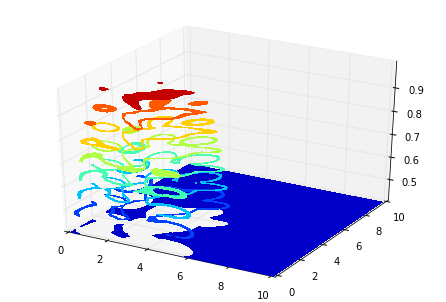

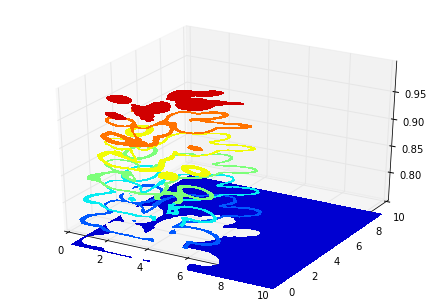

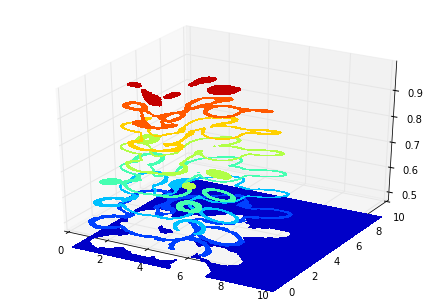

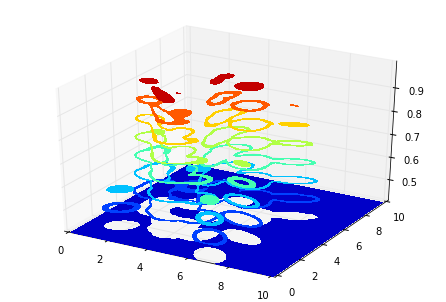

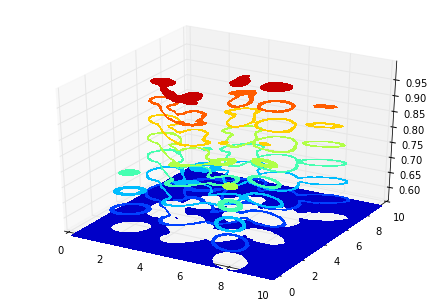

In [61]:
for f in TrueModel.frame:
    TrueModel.ShadePlot(frame=f,axtype='contourf')

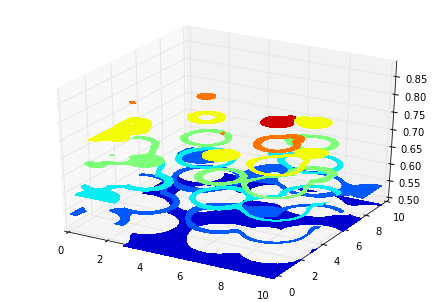

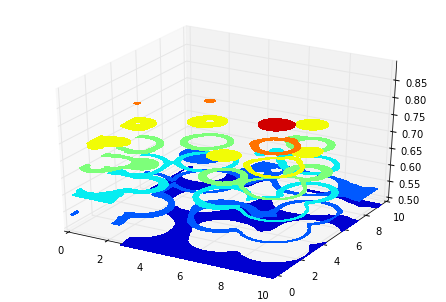

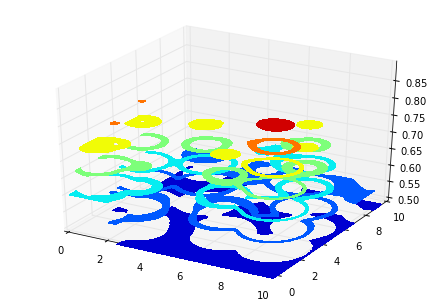

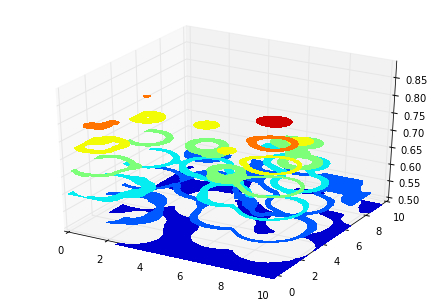

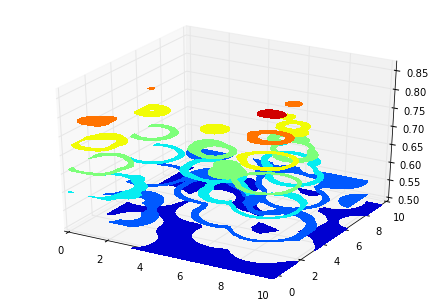

In [62]:
Model.Plot() # initial

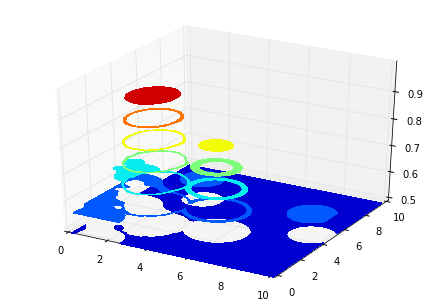

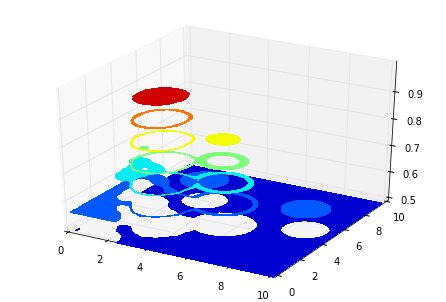

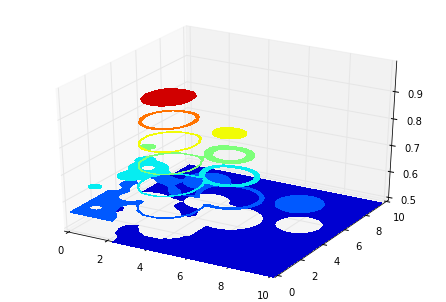

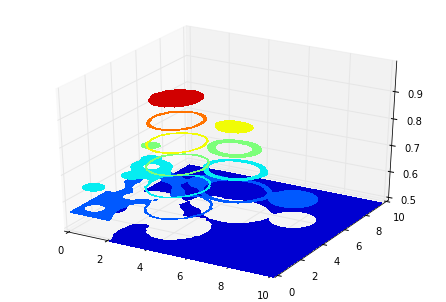

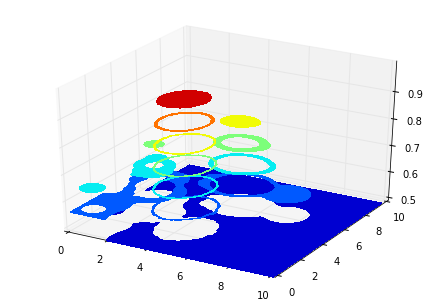

In [64]:
Model.Plot()

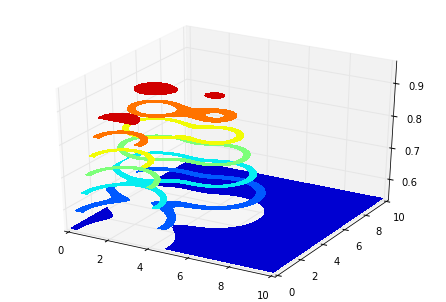

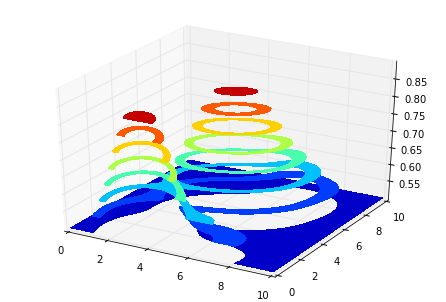

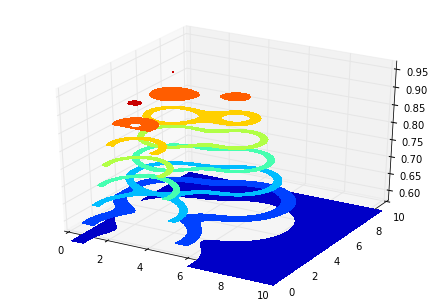

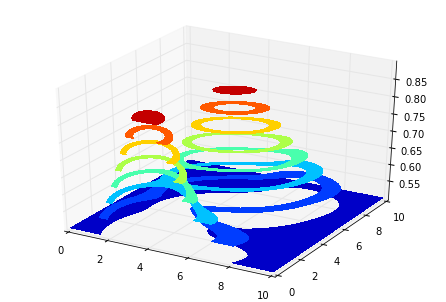

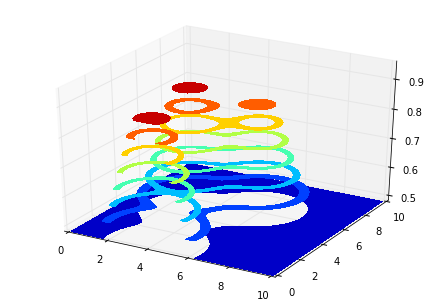

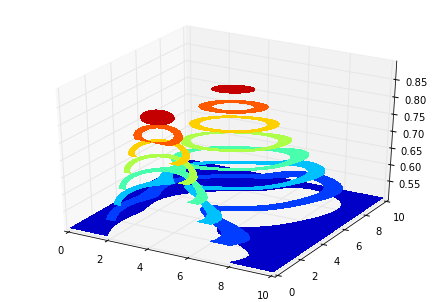

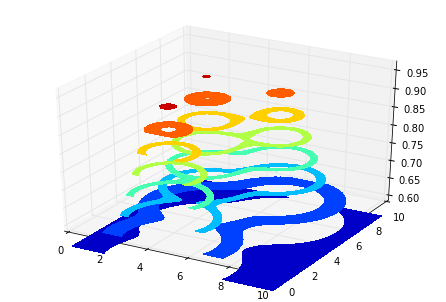

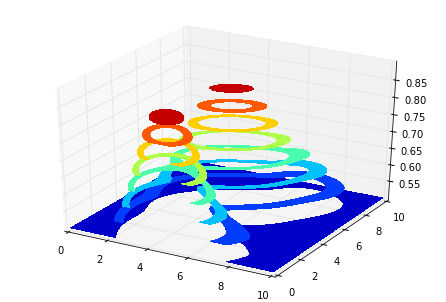

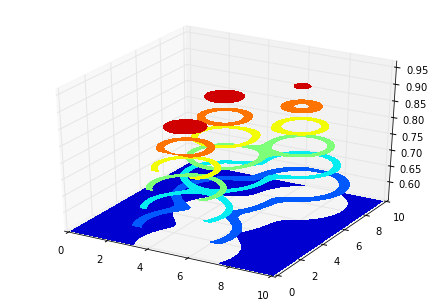

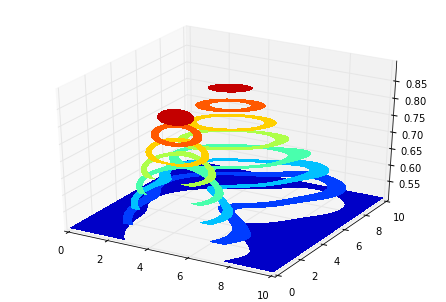

In [22]:
for f in range(5):
    fig = plt.figure()
    ax = Axes3D(fig)
    x = TrueModel.xy[:, 0]
    y = TrueModel.xy[:, 1]
    z = TrueModel.Generate()[f]
    xgrid = x.reshape(TrueModel.grid[0], TrueModel.grid[1])
    ygrid = y.reshape(TrueModel.grid[0], TrueModel.grid[1])
    zgrid = z.reshape(TrueModel.grid[0], TrueModel.grid[1])
    ax.contourf3D(xgrid, ygrid, zgrid)
    plt.savefig('data' + str(f)+'.png')
    
    fig = plt.figure()
    ax = Axes3D(fig)
    x = Model.xy[:, 0]
    y = Model.xy[:, 1]
    z = Model.predict(Model.xy, frame=f)
    xgrid = x.reshape(Model.grid[0], Model.grid[1])
    ygrid = y.reshape(Model.grid[0], Model.grid[1])
    zgrid = z.reshape(Model.grid[0], Model.grid[1])
    ax.contourf3D(xgrid, ygrid, zgrid)
    plt.savefig('result' + str(f)+'.png')
    

In [47]:
! git add uEpanechnikovMMNet.py uEpaMMNettrain.ipynb
! git commit -m 'little faster ?'
! git push

[master d4c39f8] little faster ?
 2 files changed, 250563 insertions(+), 616 deletions(-)
Counting objects: 5, done.
Delta compression using up to 4 threads.
Compressing objects: 100% (5/5), done.
Writing objects: 100% (5/5), 802.92 KiB | 0 bytes/s, done.
Total 5 (delta 3), reused 0 (delta 0)
remote: Resolving deltas: 100% (3/3), completed with 3 local objects.
To https://github.com/daigo0927/pyworks
   cda953c..d4c39f8  master -> master
